# Exercise 4.7

Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes.

One of Jack’s employees at the first location rides a bus home each night and lives near the second location. 

She is happy to shuttle one car to the second location for free. 

Each additional car still costs $2, as do all cars moved in the other direction. 

In addition, Jack has limited parking space at each location. 

If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars are kept there). 

These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

![Jack's car rental problem](ex4.2.png)

In [1]:
from dataclasses import dataclass
from typing_extensions import Self

import numpy as np
import math
from scipy.stats import poisson

import matplotlib.pyplot as plt

## Original Problem

In [2]:
# Create State class
@dataclass
class State:
    cars_loc1: int
    cars_loc2: int
    
    def __hash__(self) -> int:
        return hash((self.cars_loc1, self.cars_loc2))
    
    def __eq__(self, other) -> bool:
        if not isinstance(other, State):
            return False
        return (self.cars_loc1 == other.cars_loc1 and 
                self.cars_loc2 == other.cars_loc2)
    
    def __post_init__(self) -> None:
        assert (0 <= self.cars_loc1 <= 20 and 0 <= self.cars_loc2 <= 20), "Cars at each location must be between 0 and 20"
        
    def move_cars(self, cars_moved_l1_to_l2: int) -> tuple[Self, int]:
        assert (-5 <= cars_moved_l1_to_l2 <= 5), "Actions can only move up to 5 cars"
        assert (cars_moved_l1_to_l2 <= self.cars_loc1 and -cars_moved_l1_to_l2 <= self.cars_loc2), "Cannot move more cars than there are at the location"
        
        reward = -2 * np.abs(cars_moved_l1_to_l2)
        
        return State(
            cars_loc1=self.cars_loc1-cars_moved_l1_to_l2, 
            cars_loc2=self.cars_loc2+cars_moved_l1_to_l2,
            ), reward
    
    @staticmethod
    def poisson_prob(n: int, lambda_: int) -> float:
        return (lambda_**n / math.factorial(n)) * np.exp(-lambda_)

    def rent_car(self, location: int, rented_cars: int) -> tuple[Self, float, int]:
        match location:
            case 1:
                cars_available: int = self.cars_loc1
            case 2:
                cars_available:int = self.cars_loc2
        
        assert 0 <= rented_cars <= cars_available, "Cannot rent more cars than are available"
        
        reward = 10 * rented_cars
        
        match location:
            case 1:
                return State(
                    cars_loc1=self.cars_loc1-rented_cars, 
                    cars_loc2=self.cars_loc2,
                    )
            case 2:
                return State(
                    cars_loc1=self.cars_loc1, 
                    cars_loc2=self.cars_loc2-rented_cars,)
    
    def return_car(self, location: int, returned_cars: int) -> tuple[Self, float]:
        match location:
            case 1:
                cars_available: int = self.cars_loc1
            case 2:
                cars_available:int = self.cars_loc2
        
        assert 20 >= returned_cars + cars_available, "Cannot have than 20 cars in parking lot"
        
        match location:
            case 1:
                return State(
                    cars_loc1=self.cars_loc1+returned_cars, 
                    cars_loc2=self.cars_loc2,)
            case 2:
                return State(
                    cars_loc1=self.cars_loc1, 
                    cars_loc2=self.cars_loc2+returned_cars,)
    
    def get_all_transitions(self, action: int) -> list[tuple[Self, float, int]]:
        """
        Returns list of (next_state, probability, reward) for all possible transitions
        given an action.
        """
        # 1. Move cars overnight
        next_state, move_reward = self.move_cars(action)
        
        transitions = []
        # 2. Iterate over all possible combinations:
        for rentals_loc1 in range(next_state.cars_loc1+1):
            max_returns_loc1 = 20 - (next_state.cars_loc1 - rentals_loc1)
            for returns_loc1 in range(max_returns_loc1 + 1):
                for rentals_loc2 in range(next_state.cars_loc2 + 1):
                    max_returns_loc2 = 20 - (next_state.cars_loc2 - rentals_loc2)
                    for returns_loc2 in range(max_returns_loc2 + 1):
                        if not (0 <= rentals_loc1 <= next_state.cars_loc1):
                            continue
                        elif not (0 <= rentals_loc2 <= next_state.cars_loc2):
                            continue
                        elif not (0 <= next_state.cars_loc1 - rentals_loc1 + returns_loc1 <= 20):
                            continue
                        elif not (0 <= next_state.cars_loc2 - rentals_loc2 + returns_loc2 <= 20):
                            continue
                        
                        final_state = State(
                            cars_loc1=next_state.cars_loc1 - rentals_loc1 + returns_loc1,
                            cars_loc2=next_state.cars_loc2 - rentals_loc2 + returns_loc2,)
                        
                        # Check if valid state
                        try:
                            final_state.__post_init__()
                        except ValueError:
                            continue
                            
                        # Calculate probabilities
                        rent_loc1_prob: float = self.poisson_prob(rentals_loc1, 3)
                        return_loc1_prob: float = self.poisson_prob(returns_loc1, 3)
                        rent_loc2_prob: float = self.poisson_prob(rentals_loc2, 4)
                        return_loc2_prob: float = self.poisson_prob(returns_loc2, 2)
                        
                        probability: float = rent_loc1_prob * return_loc1_prob * rent_loc2_prob * return_loc2_prob
                        reward: int = move_reward + 10 * (rentals_loc1 + rentals_loc2)
                        
                        transitions.append((final_state, probability, reward))
                        
        return transitions

### Functions for Policy Iteration for original State class

In [69]:
# Initialize
def initialize() -> tuple[dict, dict]:
    # Initialize V(s) and pi(s) arbitrarily for all s in S
    V: dict[State, float] = {}
    policy: dict[State, int] = {}
    
    # All possible states
    for cars_loc1 in range(21):
        for cars_loc2 in range(21):
            state = State(cars_loc1, cars_loc2)
            V[state] = 0 # arbitrary
            policy[state] = 0 # don't move cars (arbitrary)
    
    return V, policy

In [70]:
# Policy Evaluation
def policy_evaluation(V: dict, policy: dict, theta: float=0.01, gamma: float=0.9) -> tuple[dict, dict]:
    eval_iteration = 0
    while True:
        delta = 0
        # Loop through states
        for state in V:
            v = V[state]
            
            # Get transitions for current policy
            transitions = state.get_all_transitions(policy[state])
            
            # Set new V based on update equation
            V[state] = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in transitions)
            
            # Set Delta
            delta = max(delta, np.abs(v - V[state]))
        
        eval_iteration += 1
        print(f"Policy Evaluation iteration {eval_iteration}, delta: {delta}")
        
        # Check if Delta less than theta
        if delta < theta:
            break
        
    return V, policy

In [71]:
# Policy Improvement
def policy_improvement(V: dict, policy: dict, gamma: float=0.9) -> tuple[dict, dict, bool]:
    policy_stable = True
    action_changes = 0
    
    # Loop through states
    for state in V:
        # Set old action
        old_action = policy[state]
        
        # Calculate value under current policy
        old_transitions = state.get_all_transitions(old_action)
        current_value = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in old_transitions)
        
        # Find best action
        best_value = float('-inf')
        best_action = old_action
        
        for action in range(-5, 6):
            try:
                # Get all transitions for this action
                transitions = state.get_all_transitions(action)
            except AssertionError:
                # Skip invalid actions
                continue
            
                            
            # Calculate value of the action
            action_value = sum(prob * (reward + gamma * V[next_state]) for next_state, prob, reward in transitions)
            
            # Update if value is better
            if action_value > best_value:
                best_value = action_value
                best_action = action
            
        # Update policy if there is a better action
        if best_value > current_value:
            policy[state] = best_action
            if old_action != best_action:
                action_changes += 1
                policy_stable = False
    
    print(f"Number of policy changes: {action_changes}")
    return V, policy, policy_stable

In [76]:
def visualize_value_policy(V, policy):
    # Create meshgrid of states
    X, Y = np.meshgrid(range(21), range(21))
    values = np.zeros((21, 21))
    actions = np.zeros((21, 21))
    
    for i in range(21):
        for j in range(21):
            state = State(i, j)
            values[i,j] = V[state]
            actions[i,j] = policy[state]
    
    # Plot values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.imshow(values, origin='lower')
    plt.colorbar(label='Value')
    plt.title('State Values')
    plt.xlabel('Cars at Location 2')
    plt.ylabel('Cars at Location 1')
    plt.xticks(range(0, 21, 5))
    plt.yticks(range(0, 21, 5))
    
    # Plot policy
    plt.subplot(122)
    plt.imshow(actions, origin='lower')
    plt.colorbar(label='Action')
    plt.title('Policy (cars to move)')
    plt.xlabel('Cars at Location 2')
    plt.ylabel('Cars at Location 1')
    plt.xticks(range(0, 21, 5))
    plt.yticks(range(0, 21, 5))
    
    plt.tight_layout()
    plt.show()

In [72]:
# Policy Iteration Loop
def policy_iteration(theta: float=0.01, gamma: float=0.9) -> tuple[dict, dict]:
    # 1. Initialization
    V, policy = initialize()
    iteration = 0
    
    while True:
        iteration += 1
        print(f"Iteration {iteration}")
        
        # 2. Policy Evaluation
        print(f"Policy Evaluation...")
        V, policy = policy_evaluation(V, policy, theta, gamma)
        
        # 3. Policy Improvement
        print(f"Policy Improvement...")
        V, policy, policy_stable = policy_improvement(V, policy, gamma)
        
        if policy_stable:
            print(f'Policy is stable!')
            break
        
    return V, policy

### Policy Iteration Sequential Run
This took about 2 hours to run, so I will try to parallelize it by vectorizing our operations.

In [ ]:
# V, policy = policy_iteration()

Iteration 1
Policy Evaluation...
Policy Evaluation iteration 1, delta: 128.68143159150108
Policy Evaluation iteration 2, delta: 88.9840515410105
Policy Evaluation iteration 3, delta: 55.05565782565117
Policy Evaluation iteration 4, delta: 30.814137257998027
Policy Evaluation iteration 5, delta: 15.799621724498763
Policy Evaluation iteration 6, delta: 7.536976059132769
Policy Evaluation iteration 7, delta: 3.3714427480243785
Policy Evaluation iteration 8, delta: 1.4376409283248108
Policy Evaluation iteration 9, delta: 0.5861307513773113
Policy Evaluation iteration 10, delta: 0.2313577715176791
Policy Evaluation iteration 11, delta: 0.0894852826085355
Policy Evaluation iteration 12, delta: 0.033899597249046565
Policy Evaluation iteration 13, delta: 0.012649625481003568
Policy Evaluation iteration 14, delta: 0.004668615256775865
Policy Improvement...
Number of policy changes: 390
Iteration 2
Policy Evaluation...
Policy Evaluation iteration 1, delta: 256.1086717133408
Policy Evaluation ite

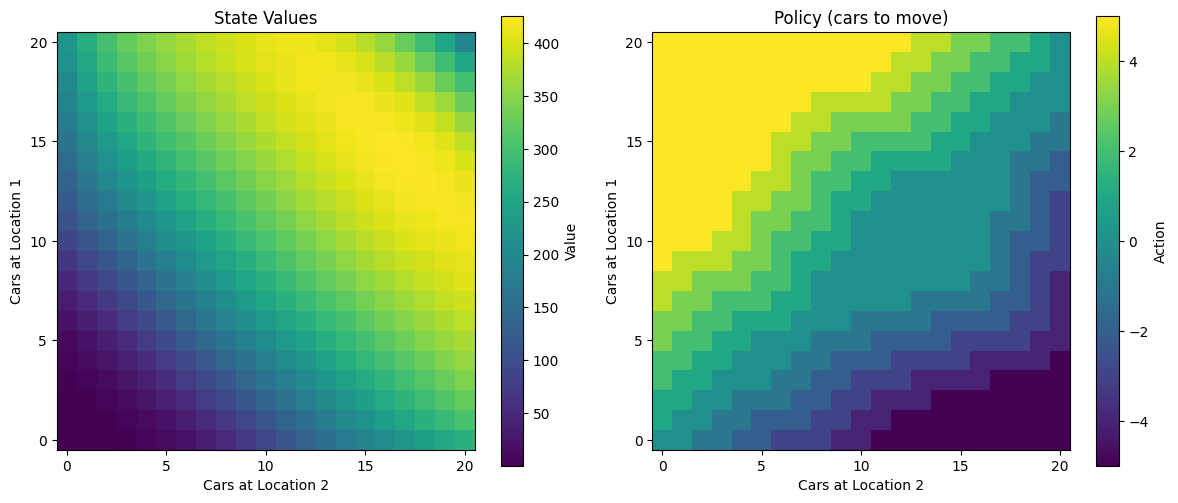

In [ ]:
# visualize_value_policy(V, policy)

## Changes to Jack's Rental Car Problem

In [ ]:
class ModifiedState(State):
    def get_all_transitions(self, action: int) -> list[tuple[Self, float, int]]:
        transitions = super().get_all_transitions(action)
        
        # Adjust transition rewards based on the exercise
        modified_transitions = []
        
        for state, prob, reward in transitions:
            # Jack's employee moves a car from loc1 to loc2 for free
            if action > 0:
                reward += 2
            
            # If there are >10 cars in either lot, then Jack pays $4 for a secondary lot for the location
            if state.cars_loc1 > 10:
                reward -= 4
            if state.cars_loc2 > 10:
                reward -= 4
            modified_transitions.append((state, prob, reward))
            
        return modified_transitions

## Parallelizing Original Problem

In [7]:
# Analyze Poisson to reduce the space for rentals and returns
def poisson_pmf(k, lambda_):
    return (lambda_**k / math.factorial(k)) * np.exp(-lambda_)

def analyze_poisson(lambda_, name):
    probs = []
    cumsum = 0
    print(f"\nAnalysis for {name} (lambda={lambda_}):")
    print("k\tProb\tCumulative")
    print("-" * 30)
    
    for k in range(15):
        prob = poisson_pmf(k, lambda_)
        cumsum += prob
        print(f"{k}\t{prob:.6f}\t{cumsum:.6f}")
        if cumsum > 0.998:
            print(f"99.8% of probability mass covered by k≤{k}")
            break

In [8]:
# Analyze each Poisson distribution
analyze_poisson(3, "rental1/return1")


Analysis for rental1/return1 (lambda=3):
k	Prob	Cumulative
------------------------------
0	0.049787	0.049787
1	0.149361	0.199148
2	0.224042	0.423190
3	0.224042	0.647232
4	0.168031	0.815263
5	0.100819	0.916082
6	0.050409	0.966491
7	0.021604	0.988095
8	0.008102	0.996197
9	0.002701	0.998898
99.8% of probability mass covered by k≤9


In [9]:
analyze_poisson(4, "rental2")


Analysis for rental2 (lambda=4):
k	Prob	Cumulative
------------------------------
0	0.018316	0.018316
1	0.073263	0.091578
2	0.146525	0.238103
3	0.195367	0.433470
4	0.195367	0.628837
5	0.156293	0.785130
6	0.104196	0.889326
7	0.059540	0.948866
8	0.029770	0.978637
9	0.013231	0.991868
10	0.005292	0.997160
11	0.001925	0.999085
99.8% of probability mass covered by k≤11


In [10]:
analyze_poisson(2, "return2")


Analysis for return2 (lambda=2):
k	Prob	Cumulative
------------------------------
0	0.135335	0.135335
1	0.270671	0.406006
2	0.270671	0.676676
3	0.180447	0.857123
4	0.090224	0.947347
5	0.036089	0.983436
6	0.012030	0.995466
7	0.003437	0.998903
99.8% of probability mass covered by k≤7


In [11]:
# Building state class that uses tensors
class TensorState(State):
    # Poisson cutoffs for rentals and returns based on 99.9% of cumulative probability
    RENTAL1_CUTOFF = 9  # lambda=3
    RETURN1_CUTOFF = 9  # lambda=3
    RENTAL2_CUTOFF = 11  # lambda=4
    RETURN2_CUTOFF = 7   # lambda=2    
    
    def __init__(self):
        # Initialize value function matrix. 0-20 cars at each location, so 21x21
        self.V = np.zeros((21, 21), dtype=float)
        
        # Initialize policy as action for each state, so 21x21 again, with each value from [-5, 5]
        self.policy = np.zeros((21, 21), dtype=int)
        
        # Initialize Q values as 21x21x11 (states x actions). 11 actions from -5 to 5
        self.Q = np.zeros((21, 21, 11), dtype=float)
        
        # Compute Poisson probabilities for possible rental and return cutoffs
        self.rental1_probs = poisson.pmf(k=np.arange(self.RENTAL1_CUTOFF + 1), mu=3)
        self.return1_probs = poisson.pmf(k=np.arange(self.RETURN1_CUTOFF + 1), mu=3)
        self.rental2_probs = poisson.pmf(k=np.arange(self.RENTAL2_CUTOFF + 1), mu=4)
        self.return2_probs = poisson.pmf(k=np.arange(self.RETURN2_CUTOFF + 1), mu=2)
        
        # Action mask to mask out actions that cannot happen (21x21x11)
        self.action_mask = self._initialize_action_mask()
    
    def _initialize_action_mask(self):
        """Initialize action mask based on valid car transfers"""
        mask = np.zeros((21, 21, 11), dtype=bool)
        
        # Loop over possible cars at loc1
        for i in range(21):
            # Loop over possible cars at loc2
            for j in range(21):
                for a_idx, action in enumerate(range(-5, 6)):
                    # Movement constraints
                    valid = (action <= i) and (-action <= j)
                    mask[i, j, a_idx] = valid

        return mask
    
    def _action_idx_to_value(self, idx) -> int:
        """Converts action index to the action value"""
        return idx - 5
    
    def get_post_action_states(self):
        """
        Get states after making the action for all possible initial states and actions.
        Returns:
            post_states: (21, 21, 11, 2) tensor with last dim being [cars_loc1, cars_loc2]
            move_rewards: (21, 21, 11) tensor of rewards for moving cars
        """
        # Possible number of cars at a location
        cars_at_loc = np.arange(21)
        # Possible actions [-5, 5]
        possible_actions = np.arange(-5, 6)
        
        # Meshgrid for states and actions
        i, j, actions = np.meshgrid(cars_at_loc, cars_at_loc, possible_actions, indexing='ij')
        
        # New states after moving cars
        post_loc1 = np.clip(i - actions, 0, 20)
        post_loc2 = np.clip(j + actions, 0, 20)
        
        # Calculate rewards for movement
        move_rewards = -2 * np.abs(actions)
        
        # Stack post_loc states into one array
        post_states = np.stack([post_loc1, post_loc2], axis=-1)
        
        return post_states, move_rewards
    
    def get_rental_return_transitions(self, post_states):
        """
        Compute transitions from rentals and returns for all states after car movements.
        
        Args:
            post_states: (21, 21, 11, 2) tensor from get_post_action_states
            
        Returns:
            - transition_probs: tensor containing probabilities for each combination
            - rental_rewards: tensor containing rewards from rentals
        """
        # Split post states into loc1 and loc 2
        cars_loc1, cars_loc2 = post_states[..., 0], post_states[..., 1]
        
        # Possible returns and rentals at each location
        possible_rentals1 = np.minimum(np.arange(self.RENTAL1_CUTOFF + 1)[:, None, None, None], cars_loc1)
        possible_returns1 = np.arange(self.RETURN1_CUTOFF + 1)
        possible_rentals2 = np.minimum(np.arange(self.RENTAL2_CUTOFF + 1)[:, None, None, None], cars_loc2)
        possible_returns2 = np.arange(self.RETURN2_CUTOFF + 1)
        
        # Calculate probabilities for each combination with einsum
        probs = np.einsum('i,j,k,l->ijkl',
                          self.rental1_probs,
                          self.return1_probs,
                          self.rental2_probs,
                          self.return2_probs,
                          )
        
        return probs
    
    def create_transition_mask(self, post_states, location):
        match location:
            case 1:
                loc = 0
                rental_cutoff = self.RENTAL1_CUTOFF
                return_cutoff = self.RETURN1_CUTOFF
            case 2:
                loc = 1
                rental_cutoff = self.RENTAL2_CUTOFF
                return_cutoff = self.RETURN2_CUTOFF
        
        # Split post states into loc1 and loc 2
        cars = post_states[..., loc] # Shape: (21, 21, 11)
        
        # Reshape cars for broadcasting:
        cars = cars.reshape(1, 1, 21, 21, 11)
        
        # Broadcast for loc1
        rentals = np.arange(rental_cutoff + 1).reshape(-1, 1, 1, 1, 1)
        returns = np.arange(return_cutoff + 1).reshape(1, -1, 1, 1, 1)
        
        mask = ((0 <= cars - rentals + returns) & (cars - rentals + returns <= 20))
        
        return mask
    
    def get_valid_transitions(self, post_states):
        """
        Get valid transitions using a mask and their probabilities

        Args:
            post_states: (21, 21, 11, 2) tensor from get_post_action_states
        
        Returns:
            valid_indices: indicies in the transitions matrix that are valid
            probs: probabilities of the transitions matrix
        """
        # Get basic action mask first
        valid_mask = self.action_mask.reshape(1, 1, 1, 1, 21, 21, 11)
        
        # Apply location 1 constraints
        mask1 = self.create_transition_mask(post_states, location=1)
        valid_mask &= mask1.reshape(self.RENTAL1_CUTOFF + 1, self.RETURN1_CUTOFF + 1, 1, 1, 21, 21, 11)
        
        # Apply location 2 constraints
        mask2 = self.create_transition_mask(post_states, location=2)
        valid_mask &= mask2.reshape(1, 1, self.RENTAL2_CUTOFF + 1, self.RETURN2_CUTOFF + 1, 21, 21, 11)
        
        # Get indices where valid
        valid_indices = np.where(valid_mask)
        
        # Calculate probabilities for valid transitions
        rentals1, returns1, rentals2, returns2, i, j, a = valid_indices
        probs = self.rental1_probs[rentals1] * self.return1_probs[returns1] * self.rental2_probs[rentals2] * self.return2_probs[returns2]
        
        return valid_indices, probs
    
    def calculate_rewards(self, valid_indices, move_rewards):
        """
        Calculate rewards for valid transitions

        Args:
            valid_indices: tuple of (rentals1, returns1, rentals2, returns2, i, j, a) indices
            move_rewards: (21, 21, 11) tensor of movement rewards from get_post_action_states

        Returns:
            total_reward: array of (rentals1, returns1, rentals2, returns2, i, j, a) rewards from valid transitions
        """
        rentals1, returns1, rentals2, returns2, i, j, a = valid_indices
        
        # Movement rewards for valid transitions
        movement_reward = move_rewards[i, j, a]
        
        # Rental rewards ($10 for each rental)
        rental_reward = 10 * (rentals1 + rentals2)
        
        # Total reward
        total_reward = movement_reward + rental_reward
        
        return total_reward
    
    def calculate_next_states(self, valid_indices, post_states):
        """
        Calculate next states for valid transitions
        
        Args:
            valid_indices: tuple of (rentals1, returns1, rentals2, returns2, i, j, a)
            post_states: (21, 21, 11, 2) tensor from get_post_action_states
            
        Returns:
            next_states: Array of shape (num_valid_transitions, 2) containing [next_cars1, next_cars2] for each valid transition
        """
        rentals1, returns1, rentals2, returns2, i, j, a = valid_indices
        
        # Get post-action states for these indices
        post_cars1 = post_states[i, j, a, 0]  # Cars at loc1 after moving
        post_cars2 = post_states[i, j, a, 1]  # Cars at loc2 after moving
        
        # Calculate next states after rentals and returns
        next_cars1 = post_cars1 - rentals1 + returns1
        next_cars2 = post_cars2 - rentals2 + returns2
        
        # Stack into single array
        next_states = np.stack([next_cars1, next_cars2], axis=1)
        
        return next_states
    
    def policy_evaluation(self, theta: float=0.01, gamma: float=0.9) -> None:
        """Policy Evaluation using vectorized operations"""
        eval_iteration = 0
        
        while True:
            delta = 0
            old_V = self.V.copy()
            
            # Get states and rewards after we take our action
            post_states, move_rewards = self.get_post_action_states()
            
            # Debug: Check move_rewards
            print("Move rewards range:", np.min(move_rewards), np.max(move_rewards))
            
            # Get valid transitions and probabilities
            valid_indices, probs = self.get_valid_transitions(post_states)
            
            # Debug: Check probabilities
            print("Probability sum:", np.sum(probs))
            print("Probability range:", np.min(probs), np.max(probs))
            
            # Get rewards
            total_rewards = self.calculate_rewards(valid_indices, move_rewards)
            
            # Debug: Check total rewards
            print("Total rewards range:", np.min(total_rewards), np.max(total_rewards))
            
            # Get next states
            next_states = self.calculate_next_states(valid_indices, post_states)
            
            # Calculate next state values
            next_state_values = self.V[next_states[:, 0], next_states[:, 1]]
            
            # Expected values for each transition
            expected_values = probs * (total_rewards + gamma * next_state_values)
            
            # Debug: Check expected values
            print("Expected values range:", np.min(expected_values), np.max(expected_values))
            
            # Need to sum up values for each starting state (i, j)
            i, j = valid_indices[4], valid_indices[5] # Starting indices
            state_indices = i * 21 + j # Flatten indices
            
            # Sum values over each state and set back to V matrix
            self.V = np.bincount(state_indices, 
                                 weights=expected_values, 
                                 minlength=21*21,
                                 ).reshape(21, 21)
            
            # Calculate delta
            delta = np.max(np.abs(old_V - self.V))
            
            eval_iteration += 1
            print(f"Policy Evaluation iteration {eval_iteration}, delta: {delta}")
            
            if delta < theta:
                break
    
    def policy_improvement(self, gamma: float=0.9):
        """Policy Improvement using vectorized operations"""
        policy_stable = True
        
        # Set old actions
        old_policy = self.policy.copy()
        
        # Get states and rewards after action is made
        post_states, move_rewards = self.get_post_action_states()
        
        # Get valid transitions and probabilities
        valid_indices, probs = self.get_valid_transitions(post_states)
        
        # Get rewards
        total_rewards = self.calculate_rewards(valid_indices, move_rewards)
        
        # Get next states
        next_states = self.calculate_next_states(valid_indices, post_states)
        
        # Calculate next state values
        next_state_values = self.V[next_states[:, 0], next_states[:, 1]]
        
        # Action values for each transition
        action_values = probs * (total_rewards + gamma * next_state_values)
        
        # Sum values for state-action pairs
        i, j, a = valid_indices[4], valid_indices[5], valid_indices[6] # (s=(s1, s2), a)
        state_action_indices = (i * 21 * 11) + (j * 11) + a # Flatten indices
        Q = np.bincount(state_action_indices, 
                        weights=action_values, 
                        minlength=21*21*11,
                        ).reshape(21, 21, 11)
        
        # Find best action for each states
        self.policy = self._action_idx_to_value(np.argmax(Q, axis=2)) # Convert action index to action value
        
        # Check if policy-stable
        policy_changes = np.sum(old_policy != self.policy)
        policy_stable = (policy_changes == 0)
        
        print(f"Number of policy changes: {policy_changes}")

        return policy_stable
    
    def visualize_iteration(self, iteration: int, save_figs: bool = False):
        """Visualize current value function and policy"""
        plt.figure(figsize=(12, 5))
        
        # Plot values
        plt.subplot(121)
        plt.imshow(self.V, origin='lower')
        plt.colorbar(label='Value')
        plt.title(f'State Values (Iteration {iteration})')
        plt.xlabel('Cars at Location 2')
        plt.ylabel('Cars at Location 1')
        plt.xticks(range(0, 21, 5))
        plt.yticks(range(0, 21, 5))
        
        # Plot policy
        plt.subplot(122)
        plt.imshow(self.policy, origin='lower')
        plt.colorbar(label='Action')
        plt.title(f'Policy (Iteration {iteration})')
        plt.xlabel('Cars at Location 2')
        plt.ylabel('Cars at Location 1')
        plt.xticks(range(0, 21, 5))
        plt.yticks(range(0, 21, 5))
        
        plt.tight_layout()
        
        if save_figs:
            plt.savefig(f'iteration_{iteration}.png')
        plt.close()
    
    def display_all_iterations(self, num_iterations):
        """Display all saved iterations in a grid"""
        # Calculate grid dimensions
        grid_size = int(np.ceil(np.sqrt(num_iterations)))
        
        plt.figure(figsize=(4*grid_size, 4*grid_size))
        for i in range(num_iterations):
            plt.subplot(grid_size, grid_size, i+1)
            img = plt.imread(f'iteration_{i+1}.png')
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Iteration {i+1}')
        
        plt.tight_layout()
        plt.show()
    
    def policy_iteration(self, theta: float=0.01, gamma: float=0.9):
        """Policy Iteration Algorithm using vectorized operations"""
        iteration = 0
        
        while True:
            iteration += 1
            print(f"\nIteration {iteration}")
            
            # Policy Evaluation
            print("Policy Evaluation...")
            self.policy_evaluation(theta, gamma)
            
            # Policy Improvement
            print("Policy Improvement...")
            policy_stable = self.policy_improvement(gamma)
            
            # Visualize and save current state
            self.visualize_iteration(iteration)
            
            if policy_stable:
                print("Policy stable!")
                break
        
        # Display all iterations at the end
        self.display_all_iterations(iteration)
        
        return self.V, self.policy

In [25]:
original_problem = TensorState()
original_problem.policy_iteration()


Iteration 1
Policy Evaluation...
Move rewards range: -10 0
Probability sum: 3460.451717175281
Probability range: 1.0853976432428951e-12 0.002654299736637786
Total rewards range: -10 210
Expected values range: -0.0005529791117995389 0.18580098156464503
Policy Evaluation iteration 1, delta: 702.6441790016019
Move rewards range: -10 0
Probability sum: 3460.451717175281
Probability range: 1.0853976432428951e-12 0.002654299736637786
Total rewards range: -10 210


: 